# Project: Investigating the TMDb-Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project I will analyze the TMDb (The Movie Database) dataset, which contains data of more than 10000 movies and features such as cast, title, director and revenue. This report explores two questions:

**Research Question 1**: How much revenue was generated by different movies genres over time?

**Research Question 2**: Which actors appeared in the most succesful (by average vote) movies between 2000 and 2015? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
df = pd.read_csv('tmdb-movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

The TMDb dataset contains 10866 movies, 20 features and three different types fo data (integer, float and text(object)). 9 features (*imdb_id*, *cast*, *homepage*, *director*, *tagline*, *keywords*, *overview*, *genres* and *production_companies*) lack data. For our research questions, the following features will be of importance:
* Research Question 1:
    * *genres*
    * *release_year*
    * *revenue_adj*

* Research Question 2:
    * *cast*
    * *original_title*
    * *release_year*
    * *vote_average*

While the data for the features *release_year*, *revenue_adj* and *vote_average* is complete and in the correct data type, we need to fix empty entries in *genres* and *cast*.

Let's have a closer look at the data of the first three entries first!

In [3]:
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


Several features (such as *cast*, *genres* and *production_companies*) contain multiple entries, which are divided by '|'. Since we need *cast* and *genres* for our research, we need to fix them in the data cleaning phase.

A visual presentation of the dataset gives us another overview of the distribution of the present data. Calling the `.hist()`-function on a DataFrame creates a histogram of each feature of the dataset. 

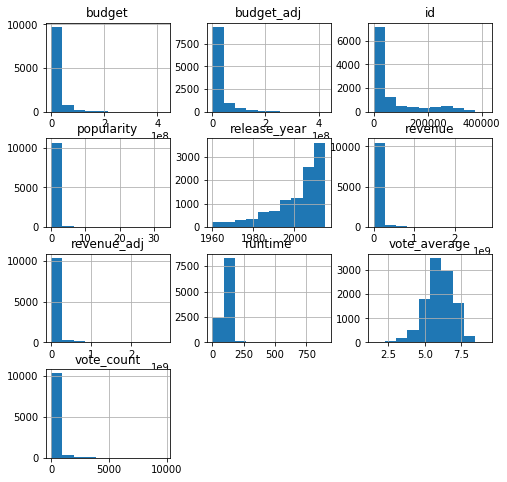

In [4]:
df.hist(figsize=(8,8));

Most histograms are skewed to the right. *release_year* is skewed to the left, so more movies in this dataset were released after 2000. *vote_average* is normally distributed, which is plausible as the data represents average votes.

___

### Data Cleaning (Replace this with more specific notes!)

In the data cleaning phase, we are going to perform the following steps:

1. Create a separate copy of the dataset for each research question
2. Drop features we don't need for our research
3. Drop empty entries
4. Split/copy entries which contain multiple data in one entry



**1. Create a separate copy of the dataset for each research question**

In [5]:
df_01 = df.copy()
df_02 = df.copy()

**2. Drop features we don't need for our research**

For research question 1, we only need *genres*, *release_year* and *revenue_adj*    
For research question 2, we only need *cast*, *original_title*, *release_year* and *vote_average*

To simply drop the unnecessary features, we first create a list of all features and drop the ones we need for our research. Then, we call the `.drop`-function to drop the remaining features in the list from our dataset.

In [6]:
columns_01 = df_01.columns.drop(['genres', 'release_year','revenue_adj'])
df_01.drop(columns_01, axis=1, inplace=True)

columns_02 = df_02.columns.drop(['cast', 'original_title', 'release_year', 'vote_average'])
df_02.drop(columns_02, axis=1, inplace=True)

**3. Drop empty entries**

For each of the remaining features, we drop empty entries by calling the `.dropna`-function. Futhermore, to assure, that we also only consider those entries, that have any revenue (which is relevant for research question 1), we only consider *revenue_adj* > 0.

In [7]:
df_01.dropna(inplace=True)
df_01 = df_01[df_01['revenue_adj'] > 0]

df_02.dropna(inplace=True)

**4. Split/copy entries which contain multiple data in one entry**

Since *genres* and *cast* contain multiple data in one entry, divided by '|', we have to split this data and create a copy of the row for each single entry.

This can be done in the following steps:
1. `.split` the text, separated by '|', to get a list of entries.
> **Extra step for Research Question 1**: Since we want to find out the total revenue of the movie genres over time, we need to assure, that the revenue is count per movie and not per genre (as many movies belong to more than 1 genre according to the data). To do this, we divide the revenue by the number of genres per movie (e.g. a movie contains a list of 3 genres, so we need to split the revenue by 3, since the revenue accounts for all three genres equally - and not per genre).     
> This will be done by creating a separate Dataframe containing the amount of genres per entry. This DataFrame will then be appended to the original DataFrame and the revenue will be divided by the amount of genres. Afterwards the extra column will be dropped again.
2.  `.assign` the list of entries to the DataFrame.
3. Create a copy of the row for each entry in the list by calling `.explode`.

In [8]:
df_01.head()

,genres,release_year,revenue_adj
0,Action|Adventure|Science Fiction|Thriller,2015,1.392446e+09
1,Action|Adventure|Science Fiction|Thriller,2015,3.481613e+08
2,Adventure|Science Fiction|Thriller,2015,2.716190e+08
3,Action|Adventure|Science Fiction|Fantasy,2015,1.902723e+09
4,Action|Crime|Thriller,2015,1.385749e+09


In [9]:
genres = df_01.genres.str.split('|')
cast = df_02.cast.str.split('|')

> ##### Extra step for Research Question 1:

In [10]:
df_genres = genres.explode() #.explode creates a row for each entry in the list
df_genres

0                 Action
0              Adventure
0        Science Fiction
0               Thriller
1                 Action
              ...       
10835              Drama
10835                War
10835            Romance
10848          Adventure
10848    Science Fiction
Name: genres, Length: 12669, dtype: object

> The first movie (index = 0) belongs to 4 different genres, so by grouping df_genres by the index, we get the number of genres per movie.

In [11]:
df_genres.groupby(df_genres.index).size()

0        4
1        4
2        3
3        4
4        3
        ..
10822    1
10828    2
10829    2
10835    5
10848    2
Name: genres, Length: 4850, dtype: int64

> Now we divide the values in *revenue_adj* by the number of genres per movie.

In [12]:
df_01['revenue_adj'] = df_01['revenue_adj'] / df_genres.groupby(df_genres.index).size()
df_01.head()

,genres,release_year,revenue_adj
0,Action|Adventure|Science Fiction|Thriller,2015,3.481115e+08
1,Action|Adventure|Science Fiction|Thriller,2015,8.704032e+07
2,Adventure|Science Fiction|Thriller,2015,9.053968e+07
3,Action|Adventure|Science Fiction|Fantasy,2015,4.756808e+08
4,Action|Crime|Thriller,2015,4.619163e+08


Now that we have adjusted the revenue_adj according to the number of genres, we can continue with assigning the list to the DataFrame and create a copy of a row for each entry in the list.

In [13]:
df_01 = df_01.assign(genres=genres)
df_01 = df_01.explode('genres')
df_01.head()

,genres,release_year,revenue_adj
0,Action,2015,3.481115e+08
0,Adventure,2015,3.481115e+08
0,Science Fiction,2015,3.481115e+08
0,Thriller,2015,3.481115e+08
1,Action,2015,8.704032e+07


In [14]:
df_02 = df_02.assign(cast=cast)
df_02 = df_02.explode('cast')
df_02.head()

,original_title,cast,vote_average,release_year
0,Jurassic World,Chris Pratt,6.5,2015
0,Jurassic World,Bryce Dallas Howard,6.5,2015
0,Jurassic World,Irrfan Khan,6.5,2015
0,Jurassic World,Vincent D'Onofrio,6.5,2015
0,Jurassic World,Nick Robinson,6.5,2015


**With this, the preparatory work is done and we can go on to the EDA.**

---

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: How much revenue was generated by different movies genres over time?

Since we want to analyse the revenue per genre over time, we need to transform our dataset so that we have a table with *release_year* on one axis and *revenue_adj* on the other, containing the adjusted revenue per genre for each year. To do this, we first group our data by *release_year* and *genres* and get a summary of (adjusted) revenues per genre per year.

In [15]:
#First step: Group by release_year and summarize values
df_01.groupby(by='release_year').sum()['revenue_adj'].head()

release_year
1960    1.069117e+09
1961    2.463622e+09
1962    1.553996e+09
1963    1.334357e+09
1964    2.397193e+09
Name: revenue_adj, dtype: float64

Now we got the aggregated adjusted revenue for all movie genres per year. This is not exactly what we want, as we want to differentiate between *genres*. Hence, we need to group by *release_year* and *genres*.

In [16]:
#Second step: Group by release_year and genres and summarize values
df_01.groupby(by=['release_year', 'genres']).sum()['revenue_adj']

release_year  genres         
1960          Action             1.595142e+08
              Adventure          1.205480e+07
              Comedy             1.392262e+08
              Drama              3.022917e+08
              Family             3.686484e+07
                                     ...     
2015          Romance            5.945442e+08
              Science Fiction    2.537127e+09
              Thriller           2.281130e+09
              War                2.165499e+08
              Western            1.584736e+08
Name: revenue_adj, Length: 882, dtype: float64

For the visualization, we want a presentation of the data that has *release_year* as index, and *genres* as columns. To get this, we use `.unstack`.

In [17]:
df_01 = df_01.groupby(by=['release_year', 'genres']).sum()['revenue_adj'].unstack()
df_01.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
release_year,,,,,,,,,,,,,,,,,,,,
1960,1.595142e+08,1.205480e+07,NaN,1.392262e+08,NaN,NaN,3.022917e+08,3.686484e+07,NaN,NaN,1.474593e+08,7.864499e+07,NaN,NaN,1.023614e+08,NaN,NaN,7.864499e+07,NaN,1.205480e+07
1961,6.838932e+07,4.464091e+08,3.937037e+08,4.496310e+08,1.061568e+08,NaN,3.423281e+08,4.082934e+08,NaN,NaN,3.647431e+07,1.458972e+07,1.061568e+08,NaN,2.310039e+07,NaN,NaN,NaN,5.270537e+07,1.568395e+07
1962,2.333135e+08,3.594613e+08,NaN,1.922253e+07,4.732291e+07,NaN,3.069472e+08,1.922253e+07,NaN,NaN,1.261479e+08,3.003520e+06,1.922253e+07,3.003520e+06,NaN,NaN,NaN,1.432079e+08,1.261479e+08,1.477732e+08
1963,2.109917e+08,1.943780e+08,NaN,6.271241e+07,3.872704e+07,NaN,1.679176e+08,NaN,NaN,NaN,1.679176e+08,8.119517e+07,NaN,2.398537e+07,1.610488e+08,NaN,NaN,2.183633e+08,7.120179e+06,NaN
1964,2.926935e+08,2.926935e+08,NaN,2.488668e+08,5.577896e+07,NaN,2.031519e+08,3.062960e+08,1.797512e+08,NaN,NaN,NaN,3.098130e+08,1.230297e+07,1.687264e+08,NaN,NaN,3.049964e+08,2.212255e+07,NaN


In [18]:
df_01.shape

(56, 20)

The dataset contains 52 rows and 20 columns. To get a better overview of the data, we visualize the dataset with an area plot.

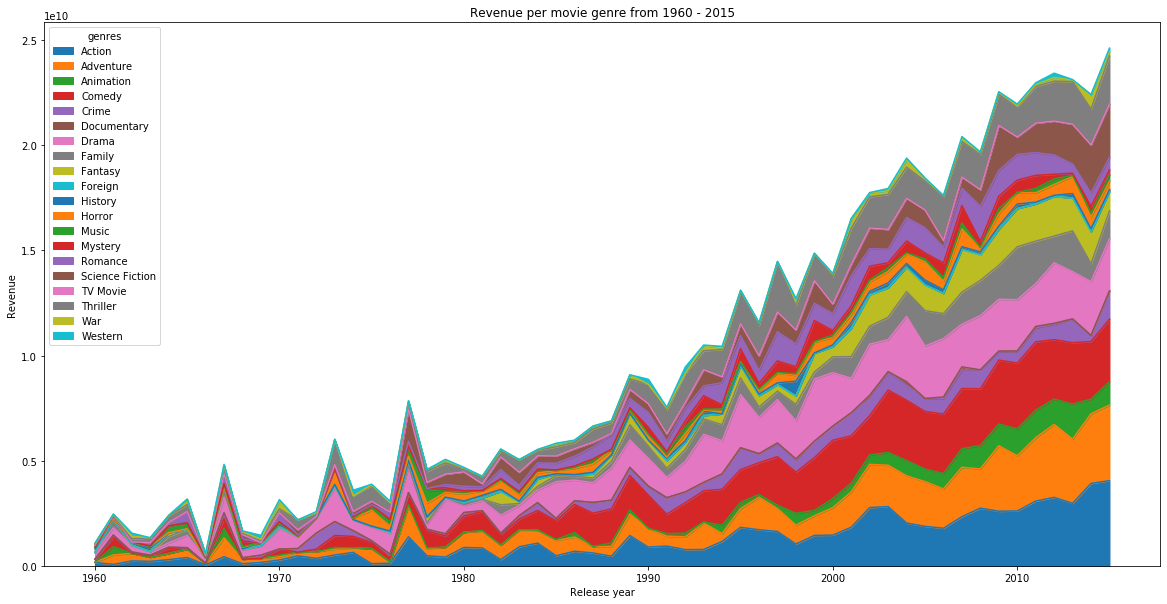

In [19]:
genres_plot = df_01.plot.area(stacked=True, title='Revenue per movie genre from 1960 - 2015', figsize=(20,10));

# function to simplify the process of renaming plot axis. It takes the plot (object) and
# the labels (as strings) for x- and y-axis and sets the labels accordingly
def rename_axis(plot, x, y):
    plot.set_xlabel(x)
    plot.set_ylabel(y)

rename_axis(genres_plot, "Release year", "Revenue");

We see now that revenue over time hugely increased from 1960 to 2015 (e.g., the revenue of action movies in 2015 alone was more than the 1960 revenue of all movies in this dataset). While we can see relative increases of revenue over time for each movie genre, this visualization is not helpful to see the total (absolute) revenue per genre. To get a better understanding of the total revenue over time, we visualize the total revenue for each genre by plotting a bar diagram and sort the values for better readability.

In [20]:
df_genres = df_01.sum(axis=0)
df_genres

genres
Action             6.886248e+10
Adventure          6.256437e+10
Animation          1.822634e+10
Comedy             7.781425e+10
Crime              2.424494e+10
Documentary        8.173034e+08
Drama              7.893604e+10
Family             3.296777e+10
Fantasy            3.002442e+10
Foreign            1.059601e+08
History            5.506139e+09
Horror             1.644660e+10
Music              6.400449e+09
Mystery            1.256284e+10
Romance            3.002697e+10
Science Fiction    3.228925e+10
TV Movie           1.459728e+07
Thriller           5.133586e+10
War                6.202184e+09
Western            2.776400e+09
dtype: float64

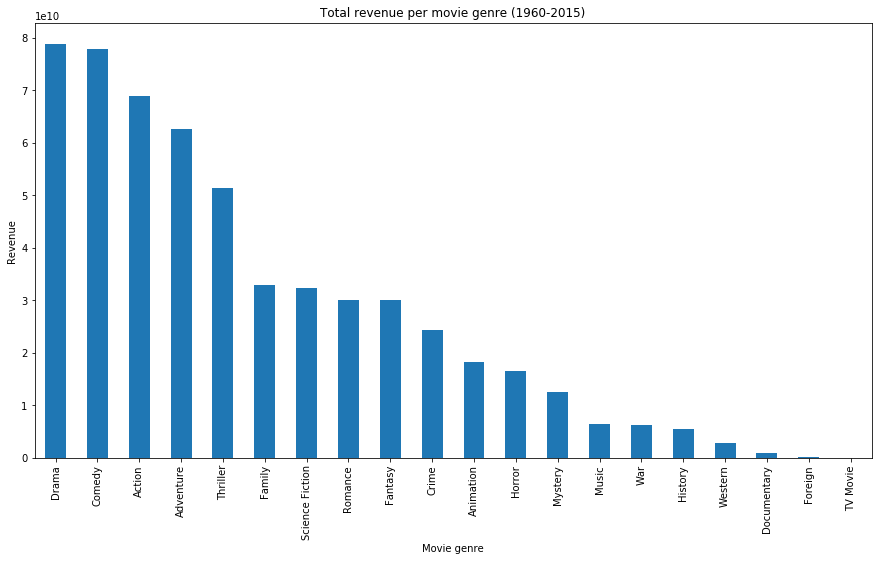

In [21]:
df_genres.sort_values(ascending=False, inplace=True)
genres_bar = df_genres.plot(kind='bar', title="Total revenue per movie genre (1960-2015)", figsize=(15,8));

rename_axis(genres_bar, "Movie genre", "Revenue");

As we can see now, the biggest revenue over time was generated by drama movies. Interestingly, in the last visualization, we might get the impression, that comedy movies generated the biggest part of revenue, at least in 2015.

In [22]:
df_01.at[2015, 'Comedy'] > df_01.at[2015, 'Drama']

True

So while the total revenue of drama movies is bigger than revenue of comedy movies, comedy movies generated more revenue in 2015. Let's have a final look on revenue growth between 1960 and 2015.

In [23]:
growth = ((df_01.sum(axis=1)[2015] / df_01.sum(axis=1)[1960]) - 1) * 100

print ("The total revenue for all movie genres in this dataset grew from 1960 to 2015 by {}%.".format(int(growth)))

The total revenue for all movie genres in this dataset grew from 1960 to 2015 by 2202%.


### Research Question 2: Which actors appeared in the most succesful (by average vote) movies between 2000 and 2015?

Since we want to find out which actors played in the most movies, that were most succesful between 2000 and 2015, we will first limit the dataset to movies, that were released between 2000 and 2015. Furthermore, we only consider those movies, that belong to the top 10% by average votes. Then, we will focus on the 10 actors, that had the most appearances in these movies.

In [24]:
#We only consider those movies, that were released between 2000 and 2015
df_02.query('release_year >= 2000', inplace=True)

#Since we don't need release_year from now on, we can drop this column
df_02.drop('release_year', axis=1, inplace=True)

df_02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34319 entries, 0 to 8887
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_title  34319 non-null  object 
 1   cast            34319 non-null  object 
 2   vote_average    34319 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


In [25]:
df_02.vote_average.quantile(.9)

7.1

The top 10% movies by average vote have at least an average vote of 7.1. In the next step, we reduce the dataset to only contain movies with an average vote of at least 7.1

In [26]:
df_02.query('vote_average >= 7.1', inplace=True)

In [27]:
df_02["original_title"].nunique()

813

Our dataset consists of 813 movies with an average vote of at least 7.1. To analyze which actors played in which of these movies, we group our dataset by the movie (*original_title*) and the actor (*cast*).

In [28]:
df_02.groupby(by=['original_title', 'cast']).sum()

vote_average
original_title       cast                              
(500) Days of Summer ChloÃ« Grace Moretz            7.3
                     Geoffrey Arend                 7.3
                     Joseph Gordon-Levitt           7.3
                     Matthew Gray Gubler            7.3
                     Zooey Deschanel                7.3
...                                                 ...
ì§‘ìœ¼ë¡œ ê°€ëŠ” ê¸¸ Choi Min-Chul                  7.1
                     Go Soo                         7.1
                     Jeon Do-yeon                   7.1
                     Kang Ji-Woo                    7.1
                     Lee Dong-Hwi                   7.1

[3637 rows x 1 columns]

Now we see which actors played in a movie. To get a corelation between all movies and all actors (to analyze the number of appearances actors had in movies), we need to transform the dataset to get a presentation of the data having movies on one axis and actors on the other. We will do this by calling `.unstack` (and dropping one level, *vote_average* row, by calling `.droplevel`).

In [29]:
df_appearance = df_02.groupby(by=['original_title', 'cast']).sum().unstack().droplevel(0, axis=1)
df_appearance.head()

cast,Larry Mullen Jr.,50 Cent,Aamir Khan,Aaron Dessner,Aaron Eckhart,Aaron Murphy,Aaron Paul,Aaron Swartz,Abbes Zahmani,Abdul Rahman Barman,...,Zita TÃ©by,Zoe Kazan,Zoe Saldana,Zooey Deschanel,ZoÃ« Kravitz,ÃdÃ¡m Varga,Ã–zge Ã–zberk,Ã‡etin Tekindor,Ã‰mile VallÃ©e,Åžafak Sezer
original_title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.3,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Years a Slave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20 Feet from Stardom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The values in the table represent average votes. NaN values mean, that there is no average vote value because the actor did not play in that movie. Hence, by counting NaN-values and subtracting the number of "True"-values, we get the number of appearances actors had in the movies.

In [30]:
df_appearance.isna().describe()

cast,Larry Mullen Jr.,50 Cent,Aamir Khan,Aaron Dessner,Aaron Eckhart,Aaron Murphy,Aaron Paul,Aaron Swartz,Abbes Zahmani,Abdul Rahman Barman,...,Zita TÃ©by,Zoe Kazan,Zoe Saldana,Zooey Deschanel,ZoÃ« Kravitz,ÃdÃ¡m Varga,Ã–zge Ã–zberk,Ã‡etin Tekindor,Ã‰mile VallÃ©e,Åžafak Sezer
count,813,813,813,813,813,813,813,813,813,813,...,813,813,813,813,813,813,813,813,813,813
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
freq,812,812,811,812,811,812,812,812,812,812,...,812,811,809,812,812,812,812,812,812,812


Here we see, how often each actor appeared in one of the movies. 50 Cent, for example, only appeared in 1 movie (for his column, the `.isna()`-value is 812 times True and 1 time False, meaning only once there is a value which is not NaN). Now we calculate the appearances of all actors and select the 10 actors with most appearances.

In [31]:
actors = df_appearance.isna().count() - df_appearance.isna().sum(axis=0)
actors = actors.sort_values(ascending=False).head(10)
actors

cast
Scarlett Johansson    10
Mark Ruffalo          10
Leonardo DiCaprio     10
Christian Bale         9
Tom Hardy              9
Emma Watson            9
Tom Hanks              9
Daniel Radcliffe       8
Rupert Grint           8
Michael Caine          8
dtype: int64

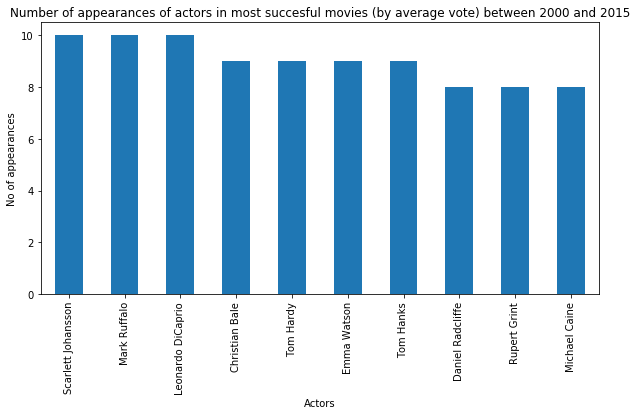

In [32]:
actors_bar = actors.plot(kind='bar', title='Number of appearances of actors in most succesful movies (by average vote) between 2000 and 2015', figsize=(10,5));

rename_axis(actors_bar, "Actors", "No of appearances");

Now we know that Scarlett Johansson, Mark Ruffalo and Leonardo DiCaprio appeared in 10 of the most succesful movies between 2000 and 2015, while Rupert Grint, Michael Caine and Daniel Radcliffe only appeared 8 times. What we don't know is whether some actors appeared in the same movies together. To analyze this, we will visualize the data in a heatmap, which enables us to see very easily which actors played together in which movie. Therefore, we first reduce the dataset to contain only the 10 actors and the movies they appeared in and drop the remaining movies. Then, for better readability and for plotting the heatmap, we replace NaN- and vote_average-values with 0 and 1 (the vote_average value is now only a placeholder to indicate which actor appeared in which movie and hence can easily be replaced). Finally, we plot the heatmap. Therefore we will use the seaborn package.

In [33]:
#get a list of the 10 actors 
actors_list = list(actors.index)

#reduce our dataset to only contain the actors and movies that are relevant
df_appearance = df_appearance[actors_list]
df_appearance.dropna(how='all', inplace=True) #by using how='all', we only delete those movies in which noone of the 10 actors appeared

In [34]:
#Display the number of NaN-values in the dataset, indicating how often actors appeared in movies
df_appearance.isna().describe()

cast,Scarlett Johansson,Mark Ruffalo,Leonardo DiCaprio,Christian Bale,Tom Hardy,Emma Watson,Tom Hanks,Daniel Radcliffe,Rupert Grint,Michael Caine
count,61,61,61,61,61,61,61,61,61,61
unique,2,2,2,2,2,2,2,2,2,2
top,True,True,True,True,True,True,True,True,True,True
freq,51,51,51,52,52,52,52,53,53,53


For Scarlett Johansson, there is 51 of 61 times a NaN(True)-value in the dataset, meaning she appeared in 10 out of 61 movies, which is correct as we saw earlier. Now we replace all NaN-values with 0 and any vote_average value > 1 with 1.

In [35]:
df_appearance.fillna(0, inplace=True)
df_appearance[df_appearance > 1] = 1

In [36]:
df_appearance

cast,Scarlett Johansson,Mark Ruffalo,Leonardo DiCaprio,Christian Bale,Tom Hardy,Emma Watson,Tom Hanks,Daniel Radcliffe,Rupert Grint,Michael Caine
original_title,,,,,,,,,,
American Psycho,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Avengers: Age of Ultron,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Batman Begins,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
Batman Unmasked: The Psychology of the Dark Knight,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Begin Again,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Toy Story of Terror!,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Warrior,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Woody Allen: A Documentary,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Every cell that does not contain a 0 indicates a movie in which an actor appeared. For better readability, we replace the index- and column-names and plot the heatmap.

In [37]:
df_appearance.index.name = 'Movies'
df_appearance.columns.name = 'Actors'

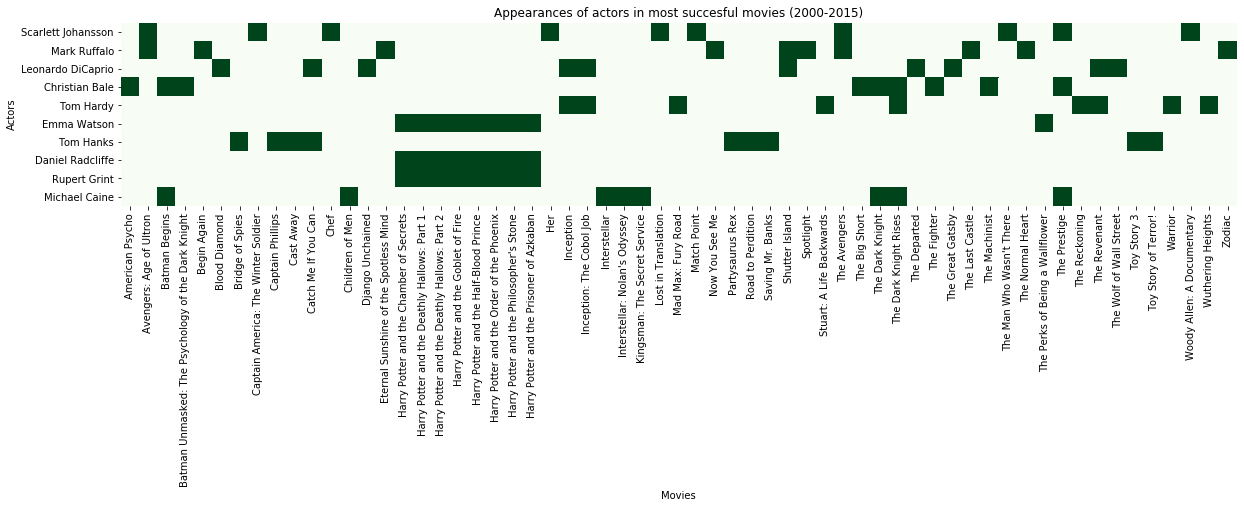

In [38]:
plt.subplots(figsize=(20,15))
plt.axes().set_title('Appearances of actors in most succesful movies (2000-2015)')
plt.xticks(rotation=90) #for better readability, we rotate the labels on x-axis by 90 degree
sns.heatmap(df_appearance.transpose(), square=True, cmap="Greens", cbar=False);

As we can see now, the three actors, that appeared 10 times in the movies (Scarlett Johansson, Mark Ruffalo and Leonardo DiCaprio), did not appear together in one movie. Nonetheless, Scarlett Johansson and Mark Ruffalo appeared together in two "Avengers"-movies, Mark Ruffalo appeared together with Leonardo DiCaprio in "Shutter Island", and Scarlett Johansson and Leonardo DiCaprio did not appear together in one of the movies we are analyzing here. Not surprisingly, Emma Watson, Rupert Grint and Daniel Radcliffe appeared together in 8 "Harry Potter" movies (which are all of the movies, Daniel Radcliffe and Rupert Grint appeared in - at least in this dataset), while Emma Watson also appeared in "The Perks of Being a Wallflower".

<a id='conclusions'></a>
## Conclusions

In **Research Question 1**, we explored the generated revenue per movie genre from 1960 - 2015. While drama movies generated the most revenue over time, comedy movies generated the most revenue in the last recorded year 2015. We found out, that the total revenue of all movie genres increased by 2202% from 1960 to 2015.
In **Research Question 2**, we analyzed which actors appeared in the most succesful movies between 2000 and 2015. Therefore we assumed that a movie is succesful if it is in the top 10% by average vote. The actors, that appeared the most often (10 times) are Scarlett Johansson, Mark Ruffalo und Leonardo DiCaprio - though there is not one succesful movie in this dataset, in which all three of them appeared together, there are two movies in which Scarlet Johansson and Mark Ruffalo appeared together and one movie in which Mark Ruffalo and Leonardo DiCaprio appeared together.


### Limitations

* Since many movies in this dataset were assigned to several movie genres, we had to distribute the revenue per movie equally to the number of genres. The result might be more accurate, if one movie is only assigned to one genre.
* According to the dataset, there were movies, that did not generate any revenue at all. It is unclear whether this is really the case or whether the dataset only lacks this information.
* According to this [post](https://www.themoviedb.org/talk/554b673992514103d20012de), TMDb listed more than 234,000 movies by 2015, so the present dataset, which only contains 10866 movies released between 1960 and 2015, is far from being complete. Hence the significance of the presented results is valid for this provided dataset only.
* By dropping missing/empty values from variables that we explore, we risk getting biased results.
